# P7 Credit Risk (EDA pour prise en main des data)
**Présentation du projet**
- Sujet : aide à la décision concernant l'octroi de crédit 
- Objectif : prédire les personnes qui risquent d'être en défaut de paiement en fonction de leur comportement dans le passé
- Data : historique des donnéées comportementales sur les crédits qui précèdent la demande actuelle des clients 
- Problématique : classification supervisée qui retourne un score qui mesure la probabilité que le client appartienne à la classe possitive (client risqué)

**Mise en oeuvre**
- Versionning sous Git/Github
- Data processing (data cleaning, feature engineering)
- Modélisation via LightGBM (kernel récupéré de Kaggle)
- Evaluation (AUC, courbe ROC...)
- Automatisation des traitements
- Analyses exploratoires et identification des 20 features les + importantes

## Packages import

In [1]:
# In-built general packages
import gc # Garbage Collector pour supprimer de l'utilisation mémoire
import time
from contextlib import contextmanager

# Data manipulation
import numpy as np
import pandas as pd

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Data imputing
from sklearn.impute import SimpleImputer

# Data encoding (variables catégorielles)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Classifier
# lightgbm est 1 bibliothèque de Microsoft qui fournit 1 algo d'amplification du gradien + efficace + rapide que les autres bibliothèques
from lightgbm import LGBMClassifier # algo d'amplification du gradient (Gradient Boosting Machine) ou XGBoost/CatBoost basés sur des tree
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score # évaluation des modèles de classification
from sklearn.model_selection import KFold, StratifiedKFold # stratégies de classification

# Warnings management
import warnings
warnings.simplefilter(action='ignore')
#warnings.simplefilter(action='ignore', category=FutureWarning)

# I. EDA - Application train

## I.1. Data import

In [2]:
# Lecture des data application : demandes de crédits
df = pd.read_csv('../input/application_train.csv', nrows= None)
print(f'Dimensions de application train : {df.shape}')

Dimensions de application train : (307511, 122)


## I.2. Target

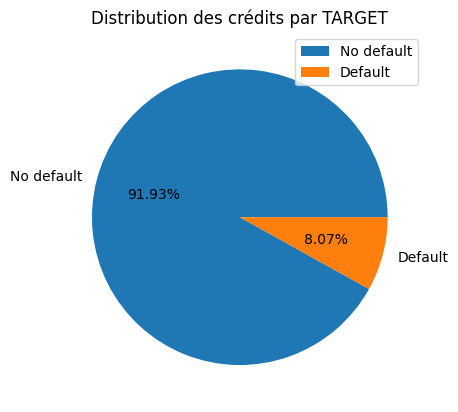

In [62]:
# Distribution de la target 
df_target = df['TARGET'].value_counts().reset_index()
df_target['TARGET_NAME'] = df_target['index'].map({0.0:'No default', 1.0:'Default'})
plt.pie(df_target['TARGET'], labels=df_target['TARGET_NAME'], autopct='%1.2f%%', pctdistance=0.6)
plt.title('Distribution des crédits par TARGET')
plt.legend()
plt.show()

## I.3. Missing data

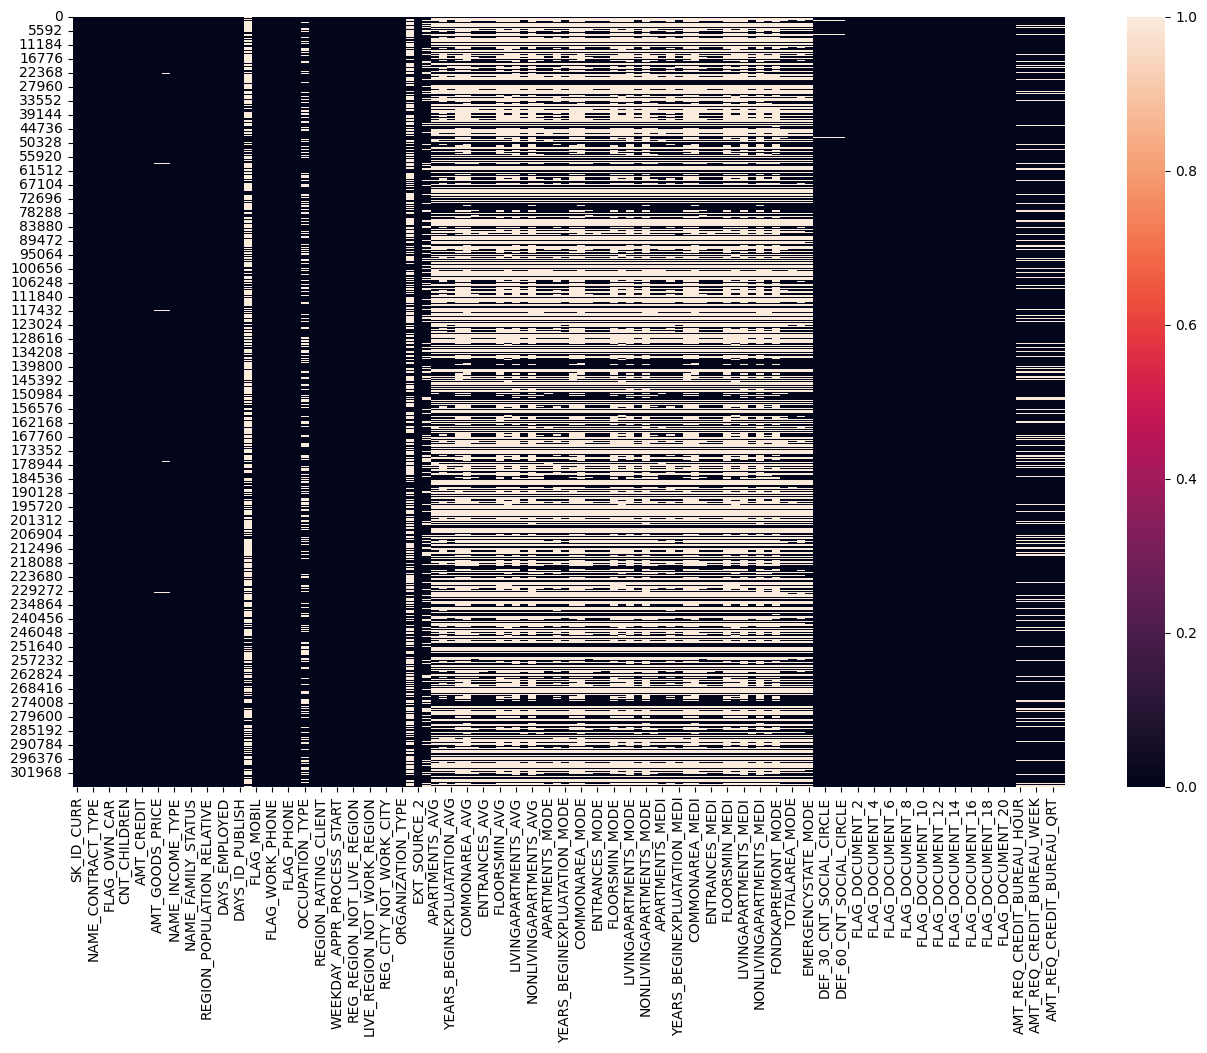

In [4]:
fig = plt.figure(figsize=(16,10))
sns.heatmap(df.isna(), cbar=True)
plt.show()

In [5]:
# Identification des variables pour lesquelles les données manquantes représentent moins de 10% des échantillons toute classe confondue 
df_missing_10 = pd.DataFrame(df.isna().mean()*100, columns=['missing_%'])
df_missing_10 = df_missing_10[(df_missing_10['missing_%']<10) & (df_missing_10['missing_%']>0)]
print(f'Variables avec données manquantes < 10% :\n{df_missing_10}')

Variables avec données manquantes < 10% :
                          missing_%
AMT_ANNUITY                0.003902
AMT_GOODS_PRICE            0.090403
NAME_TYPE_SUITE            0.420148
CNT_FAM_MEMBERS            0.000650
EXT_SOURCE_2               0.214626
OBS_30_CNT_SOCIAL_CIRCLE   0.332021
DEF_30_CNT_SOCIAL_CIRCLE   0.332021
OBS_60_CNT_SOCIAL_CIRCLE   0.332021
DEF_60_CNT_SOCIAL_CIRCLE   0.332021
DAYS_LAST_PHONE_CHANGE     0.000325


In [6]:
# Identification des variables pour lesquelles les données manquantes représentent moins de 10% des échantillons sur la classe minoritaire (défaut de paiement) 
df_missing_10 = pd.DataFrame(df[df['TARGET']==1].isna().mean()*100, columns=['missing_%'])
df_missing_10 = df_missing_10[(df_missing_10['missing_%']<10) & (df_missing_10['missing_%']>0)]
print(f'Variables avec données manquantes < 10% sur la classe minoritaire:\n{df_missing_10}')


Variables avec données manquantes < 10% sur la classe minoritaire:
                          missing_%
AMT_GOODS_PRICE            0.084592
NAME_TYPE_SUITE            0.281974
EXT_SOURCE_2               0.209466
OBS_30_CNT_SOCIAL_CIRCLE   0.145015
DEF_30_CNT_SOCIAL_CIRCLE   0.145015
OBS_60_CNT_SOCIAL_CIRCLE   0.145015
DEF_60_CNT_SOCIAL_CIRCLE   0.145015


In [7]:
# Identification des variables pour lesquelles les données manquantes représentent moins de 10% des échantillons sur la classe majoritaire (pas de défaut de paiement) 
df_missing_10_majo = pd.DataFrame(df[df['TARGET']==0].isna().mean()*100, columns=['missing_%'])
df_missing_10_majo = df_missing_10_majo[(df_missing_10_majo['missing_%']<10) & (df_missing_10_majo['missing_%']>0)]
print(f'Variables avec données manquantes < 10% sur la classe majoritaire :\n{df_missing_10_majo}')

Variables avec données manquantes < 10% sur la classe majoritaire :
                          missing_%
AMT_ANNUITY                0.004245
AMT_GOODS_PRICE            0.090914
NAME_TYPE_SUITE            0.432282
CNT_FAM_MEMBERS            0.000707
EXT_SOURCE_2               0.215080
OBS_30_CNT_SOCIAL_CIRCLE   0.348443
DEF_30_CNT_SOCIAL_CIRCLE   0.348443
OBS_60_CNT_SOCIAL_CIRCLE   0.348443
DEF_60_CNT_SOCIAL_CIRCLE   0.348443
DAYS_LAST_PHONE_CHANGE     0.000354


In [8]:
# Tableau des valeurs manquantes
freq = df.isna().sum() 
avg = round(df.isna().mean()*100,2)
df_missing = pd.DataFrame()
df_missing['col'] = freq.index
df_missing['missing'] = freq.values
df_missing['missing_freq_%'] = avg.values
df_missing = df_missing.sort_values(by='missing', ascending=False)
print(f"Nb de colonnes avec des data manquantes : {df_missing[df_missing['missing']>0].shape[0]}")
display(df_missing)

Nb de colonnes avec des data manquantes : 67


,col,missing,missing_freq_%
76,COMMONAREA_MEDI,214865,69.87
48,COMMONAREA_AVG,214865,69.87
62,COMMONAREA_MODE,214865,69.87
70,NONLIVINGAPARTMENTS_MODE,213514,69.43
56,NONLIVINGAPARTMENTS_AVG,213514,69.43
...,...,...,...
15,NAME_HOUSING_TYPE,0,0.00
14,NAME_FAMILY_STATUS,0,0.00
13,NAME_EDUCATION_TYPE,0,0.00
12,NAME_INCOME_TYPE,0,0.00


## I.4. Imputing data

In [9]:
# Distribution des types de data
df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [10]:
# Traitement des variables quantitatives manquantes
col_qty_missing = pd.DataFrame(df.select_dtypes('float64').isna().sum().sort_values(), columns=['missing'])
col_qty_missing = list(col_qty_missing[col_qty_missing['missing']>0].index)
print(f'Liste des var quantitatives avec données manquantes {len(col_qty_missing)} : \n{col_qty_missing}')

# Imputation des Nan par la médiane insensible aux valeurs extrêmes
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
df[col_qty_missing] = imp_median.fit_transform(df[col_qty_missing])

# Résultat après imputation 
print(f"\nAprès imputation : {df.select_dtypes('float64').isna().sum().sum()} valeurs quantitatives manquantes")

Liste des var quantitatives avec données manquantes 61 : 
['DAYS_LAST_PHONE_CHANGE', 'CNT_FAM_MEMBERS', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SOURCE_3', 'TOTALAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MEDI', 'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'ENTRANCES_AVG', 'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'ELEVATORS_MODE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'EXT_SOURCE_1', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MODE', 'LANDAREA_AVG'

In [11]:
# Traitement des variables catégorielles manquantes
col_cat_missing = pd.DataFrame(df.select_dtypes('object').isna().sum().sort_values(), columns=['missing'])
print(col_cat_missing)
col_cat_missing = list(col_cat_missing[col_cat_missing['missing']>0].index)
print(f'\nListe des var catégorielles avec données manquantes : \n{col_cat_missing}')

# Imputation des Nan par la valeur catégorielle la + fréquente
imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[col_cat_missing] = imp_most_frequent.fit_transform(df[col_cat_missing])

# Résultat après imputation 
print(f"\nAprès imputation : {df.select_dtypes('object').isna().sum().sum()} valeurs catégorielles manquantes")

                            missing
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
WEEKDAY_APPR_PROCESS_START        0
ORGANIZATION_TYPE                 0
NAME_TYPE_SUITE                1292
OCCUPATION_TYPE               96391
EMERGENCYSTATE_MODE          145755
HOUSETYPE_MODE               154297
WALLSMATERIAL_MODE           156341
FONDKAPREMONT_MODE           210295

Liste des var catégorielles avec données manquantes : 
['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'EMERGENCYSTATE_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'FONDKAPREMONT_MODE']

Après imputation : 0 valeurs catégorielles manquantes


## I.5. Outliers

In [12]:
# Traitement des outliers
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.487841,5.383163e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.005538,0.006055,0.029723,0.231293,0.229631,1.778463
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.461065,3.692890e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.078014,0.103037,0.190728,0.856810,0.744059,1.765523
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [13]:
# Outlier : DAYS_BIRTH < 0
(df['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

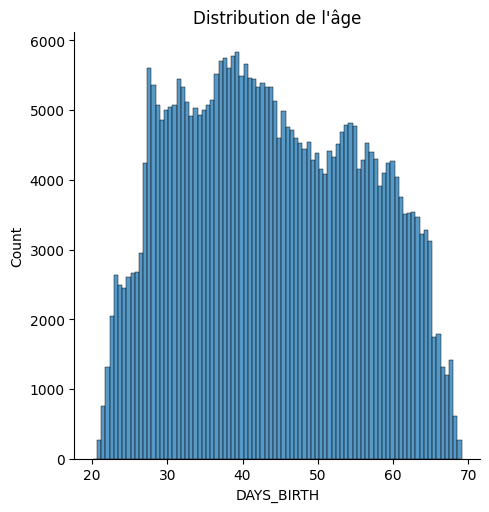

In [54]:
# Distribution de l'âge
sns.displot(df['DAYS_BIRTH']/-365)
plt.title('Distribution de l\'âge')
plt.show()

In [15]:
# On ajoute AGE + TR_AGE 
df['AGE'] = df['DAYS_BIRTH']/-365
df['TR_AGE'] = pd.cut(df['AGE'], bins=np.linspace(20, 70, num=6)) # split en 6 tranches d'âge de 10 ans
df[['AGE', 'TR_AGE', 'DAYS_BIRTH']]

,AGE,TR_AGE,DAYS_BIRTH
0,25.920548,"(20.0, 30.0]",-9461
1,45.931507,"(40.0, 50.0]",-16765
2,52.180822,"(50.0, 60.0]",-19046
3,52.068493,"(50.0, 60.0]",-19005
4,54.608219,"(50.0, 60.0]",-19932
...,...,...,...
307506,25.553425,"(20.0, 30.0]",-9327
307507,56.917808,"(50.0, 60.0]",-20775
307508,41.002740,"(40.0, 50.0]",-14966
307509,32.769863,"(30.0, 40.0]",-11961


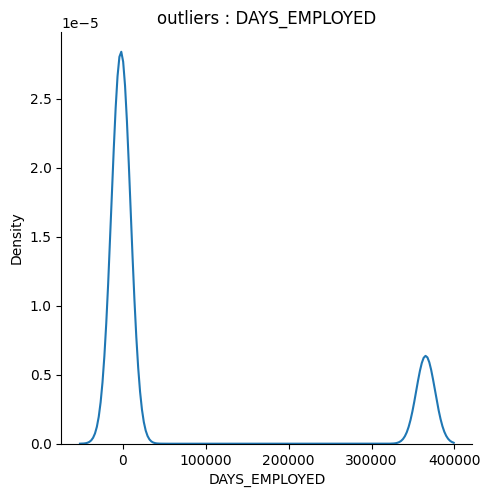

Nbre de lignes Tq DAYS_EMPLOYED > 70 ans 55374
Liste des valeurs > 70 ans : [365243]


In [16]:
# Outlier : DAYS_EMPLOYED
sns.displot(df['DAYS_EMPLOYED'], kind='kde') # distribution
plt.title('outliers : DAYS_EMPLOYED')
plt.show()

# max(DAYS_EMPLOYED) = 365243 > 1000 années, or ne peut pas être > 70 ans (25500 jours)
print(f"Nbre de lignes Tq DAYS_EMPLOYED > 70 ans {df[df['DAYS_EMPLOYED']>25500].shape[0]}")
print(f"Liste des valeurs > 70 ans : {df[df['DAYS_EMPLOYED']>25500]['DAYS_EMPLOYED'].unique()}")

# Imputation de la valeur extrême par Nan (ou par la médiane/moyenne)
df.loc[df['DAYS_EMPLOYED']>25500, 'DAYS_EMPLOYED'] = np.nan

## I.6. Features correction

In [17]:
# Analyse des catégories de type FLAG censées contenir que 2 valeurs
for col in ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']:
    print(df[col].value_counts())

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64
Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64


In [18]:
# Nettoyage des data catégorielles incohérentes (cencées contenir que 2 valeurs)
df = df[df['CODE_GENDER'] != 'XNA']

## I.7. Features encoding

In [20]:
# LabelEncoding pour les varaiables catégorielles à 2 valeurs (flag : 0/1)
lab_encoder = LabelEncoder()
col_cat = list(df.select_dtypes('object').columns)
cnt = 0
print('Label encodage pour les variables catégorielles suivantes à 2 valeurs :')
for col in col_cat :
    if df[col].nunique() <= 2 :
        cnt+=1
        df[col] = lab_encoder.fit_transform(df[col])
        print(f'- {col}')
print(f'Nombre de variables encodées avec Label Encoding : {cnt}')

Label encodage pour les variables catégorielles suivantes à 2 valeurs :
Nombre de variables encodées avec Label Encoding : 0


In [21]:
# OneHotEncoding pour les variables catégorielles à plus de 2 valeurs
col_origine = list(df.columns)
col_cat = list(df.select_dtypes('object').columns)

# Encodage One-hot des variables catégorielles (dans df on ne conserve pas les var catégorielles d'origine)
df = pd.get_dummies(df, columns=col_cat, dummy_na=False)

# Nouveaux libellés des colonnes encodées : "columnName_value"
new_col = [c for c in list(df.columns) if c not in col_origine]
print(f'{len(new_col)} Nouvelles colonnes one hot encodées :\n{new_col}')
df[new_col].head()

129 Nouvelles colonnes one hot encodées :
['NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_House / apartment'

,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0


## I.8. Exploratory analysis 

         TR_AGE        AGE    TARGET
0  (20.0, 30.0]  26.621988  0.114574
1  (30.0, 40.0]  35.123167  0.095836
2  (40.0, 50.0]  44.756079  0.076508
3  (50.0, 60.0]  54.976568  0.061298
4  (60.0, 70.0]  63.355933  0.049214


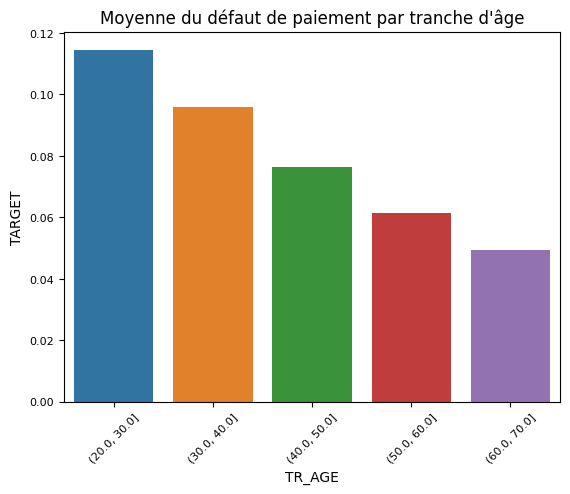

In [22]:
# Distribution des défauts de paiement (TARGET) par tranches d'âge
df_tr_age = df[['TR_AGE', 'AGE', 'TARGET']].copy()
target_groupby_tr_age = df_tr_age.groupby('TR_AGE').mean().reset_index()
print(target_groupby_tr_age)

# barplot
df_tr_age = df[['TR_AGE', 'AGE', 'TARGET']].copy()
target_groupby_tr_age = df_tr_age.groupby('TR_AGE').mean().reset_index()
sns.barplot(data=target_groupby_tr_age, x='TR_AGE', y='TARGET')
plt.title('Moyenne du défaut de paiement par tranche d\'âge')
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [24]:
# Correlation des features avec la target
cor = df.corr()['TARGET'].sort_values(ascending=False)
print(f'Top 20 :\n{cor.head(20)}')
print(f'\nBottom 20 :\n{cor.tail(20)}')

Top 20 :
TARGET                                               1.000000
DAYS_BIRTH                                           0.078242
DAYS_EMPLOYED                                        0.074957
REGION_RATING_CLIENT_W_CITY                          0.060895
REGION_RATING_CLIENT                                 0.058901
NAME_INCOME_TYPE_Working                             0.057483
DAYS_LAST_PHONE_CHANGE                               0.055219
CODE_GENDER                                          0.054710
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050992
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049822
FLAG_EMP_PHONE                                       0.045984
REG_CITY_NOT_LIVE_CITY                               0.044394
FLAG_DOCUMENT_3                                      0.044341
DAYS_REGISTRATION                                    0.041976
LIVE_CITY_NOT_WORK_CITY                              0.032517

# II. Data pre-processing 
- Fonctions d'automatisation des traitements de préparation des données 
- Généralisation de ce qui a été fait dans le chapitre **I. EDA** pour l'ensemble des tables/fichiers csv
- Ces fonctions sont **exécutées en chaîne** dans le chapitre **III.2 Main()** 

In [25]:
####################
# General functions
####################
# Suppression des individus SSI le nombre de valeurs manquante <= 10% de l'échantillon d'une classe donnée
# valable pour les variables quantitatives et catégorielles
def fct_dropna(df):
    dict_classes = {0:'majoritaire', 
                    1:'minoritaire'
    }
    list_df_classe = [] # liste pour contenir les 2 dataframes : df découpé par classe 
    
    # Suppression des échantillons de valeurs manquantes par classe
    for classe, val in dict_classes.items(): 
        # Echantilons par classe 
        list_df_classe.append(None)
        df_classe = df[df['TARGET']==classe].copy()
        taille_classe = df_classe.shape[0]

        # Identification des variables pour lesquelles le nbre de valeurs manquantes est <= 10% de la taille de classe
        df_missing_10 = pd.DataFrame(df[df['TARGET']==classe].isna().sum(), columns=['missing'])
        df_missing_10['missing_%'] = round(100*df_missing_10['missing']/taille_classe, 2)
        df_missing_10 = df_missing_10[(df_missing_10['missing_%']<=10) & (df_missing_10['missing_%']>0)]
        df_missing_10 = df_missing_10.sort_values(by='missing_%', ascending=False) 

        # Liste des variables
        cols = df_missing_10.index
        print(f'Classe {classe} {val}')
        print('-'*50) 
        
        # dropna par classe
        nb_to_be_deleted = df_missing_10['missing'].sum() 
        if nb_to_be_deleted > 0:
            print(f"NaN à supprimer : {nb_to_be_deleted}")
            print(f'Liste des NaN à supprimer Tq données manquantes <= 10% :\n{df_missing_10}')
            df_classe.dropna(axis=0, subset=cols, inplace=True)
            print(f'\nNombre d\'échantillon avant suppression NaN : {taille_classe}, après suppression NaN : {df_classe.shape[0]}')
            print(f'Nombre d\'échantillon supprimés : {taille_classe-df_classe.shape[0]} ({(taille_classe-df_classe.shape[0])/taille_classe:.2f}%)')
        else:
            print('Pas de NaN à supprimer !')
        # save le df par classe dans 1 liste
        list_df_classe[classe] = df_classe.copy()
        print('')

    # Dataframe résultat de la concaténation des dropna par classes 
    df = pd.concat([list_df_classe[0], list_df_classe[1]], axis=0, ignore_index=True)

    # Retourne les données après dropna
    return df

# Imputation des variables quantitatives NaN par la médiane
# Imputation des variables catétégorielles NaN par most_frequent 
# SSI le nombre de valeurs manquantes > 10% de l'échantillon d'une classe donnée 
def fct_fillna(df):
    dict_classes = {0:'majoritaire', 
                    1:'minoritaire'
    }
    ###################################################
    # Imputation des variables quantitatives par classe
    ###################################################
    df2 = df.copy()
    df2 = df2[['TARGET'] + list(df.select_dtypes('float64').columns)]
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    for classe, val in dict_classes.items():
        taille_classe = df2[df2['TARGET']==classe].shape[0] # taille échantillon par classe
        df_missing_10 = pd.DataFrame(df2[df2['TARGET']==classe].isna().sum(), columns=['missing'])
        df_missing_10['missing_%'] = round(100*df_missing_10['missing']/taille_classe, 2)
        df_missing_10 = df_missing_10[df_missing_10['missing_%']>10]
        df_missing_10 = df_missing_10.sort_values(by='missing_%', ascending=False)

        # Liste des variables quantitatives à imputer
        cols = df_missing_10.index
        print(f'Classe {classe} {val} (var quantitatives)')
        print('-'*50)

        # Imputation quantitative par classes
        nb_to_be_imputed = df_missing_10['missing'].sum() # nombre d'échantillon NaN à imputer
        if nb_to_be_imputed > 0:
            print(f"NaN à imputer : {nb_to_be_imputed}")
            print(f'Détail des NaN à imputer (par la médiane) Tq données manquantes > 10% :\n{df_missing_10}')
            df.loc[df['TARGET']==classe, cols] = imp_median.fit_transform(df[df['TARGET']==classe][cols])
            nb_nan = df[df['TARGET']==classe][cols].isna().sum().sum() # NaN restant
            print(f"\nNaN après imputation : {nb_nan}, NaN imputés : {nb_to_be_imputed-nb_nan}")
        else:
            print('Pas de NaN à imputer !')
        print('')

    ###################################################
    # Imputation des variables catégorielles par classe
    ###################################################
    df2 = df.copy()
    df2 = df2[['TARGET'] + list(df2.select_dtypes('object').columns)]
    imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    
    for classe, val in dict_classes.items():
        taille_classe = df2[df2['TARGET']==classe].shape[0] # taille échantillon par classe
        df_missing_10 = pd.DataFrame(df2[df2['TARGET']==classe].isna().sum(), columns=['missing'])
        df_missing_10['missing_%'] = round(100*df_missing_10['missing']/taille_classe, 2) 
        df_missing_10 = df_missing_10[df_missing_10['missing_%']>10]
        df_missing_10 = df_missing_10.sort_values(by='missing_%', ascending=False)
        
        # Liste des colonnes catégorielles à imputer
        cols = df_missing_10.index
        print(f'Classe {classe} {val} (var catégorielles)')
        print('-'*50)
        
        # Imputation catégorielle par classes   
        nb_to_be_imputed = df_missing_10['missing'].sum() # nombre d'échantillon NaN à imputer
        if nb_to_be_imputed > 0:
            print(f"NaN à imputer : {nb_to_be_imputed}")
            print(f'Détail des NaN à imputer (par most frequent) Tq données manquantes > 10% :\n{df_missing_10}')
            df.loc[df['TARGET']==classe, cols] = imp_most_frequent.fit_transform(df[df['TARGET']==classe][cols])
            nb_nan = df[df['TARGET']==classe][cols].isna().sum().sum() # NaN restant
            print(f"NaN après imputation : {nb_nan}, NaN imputés : {nb_to_be_imputed-nb_nan}")
        else:
            print('Pas de NaN à imputer !')
        print('')

    # Retourne les données après imputation
    return df

# Fonction générale de tratement des Nan par classe(TARGET) au niveau de Application 
def fct_dropna_fillna(df):
    df = fct_dropna(df) # suppression NaN si valeurs manquantes <= 10% de l'échantillon par classe
    df = fct_fillna(df) # imputation NaN par la médiane si valeurs manquantes > 10% de l'échantillon par classe
    return df

In [26]:
# Remplacement des NaN par 0 pour les colonnes aggrégats sans correspondance dans la table gauche jointe (df)
# Utilisé dans le preprocessing des fichiers/tables après chaque jointure gauche effectuée.
# A distinguer du traitement général des NaN, effectué au niveau du fichier/table Application
"""
Paramètres :
- df : dataframe qui correspond à la table cible de la jointure gauche des aggrégats
- cols_agg : liste des colonnes aggrégats
- title : nom de l'aggrégation effectuée
Output:
- df : dataframe dont les valeurs NaN des colonnes aggrégées ont été remplacées
       par 0 pour indiquer que l'indicateur n'existe pas.
"""
def fct_fillna_agg(df, cols_agg, title):
    print(f"\nAggrégat {title} - nombre de NaN (suite aux left join) à remplacer par 0 :\n{(df[cols_agg].isna().sum()).sort_values(ascending=False)}\n")
    df[cols_agg] = df[cols_agg].fillna(value=0, axis=0)
    print(f"Nombre de NaN restant : {df[cols_agg].isna().sum().sum()}")
    return df

In [27]:
###########################
# General functions (suite)
###########################
# Pour le calcul de la durée des traitements (s'utilise avec "with")
@contextmanager
def fct_timer(title):
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0:.0f}")

# Label encoding (encodage binaire) pour les var catégorielles avec seulement 2 valeurs (flag : 0/1)
def fct_label_encoder(df, title):
    lab_encoder = LabelEncoder()
    col_cat = list(df.select_dtypes('object').columns)
    cnt = 0
    for col in col_cat :
        if df[col].nunique() <= 2 :
            cnt+=1
            print(f'Table {title} - Label encodage pour la variable binaire : {col}')
            df[col] = lab_encoder.fit_transform(df[col])
    print(f'Table {title} - nombre de variables binaires Label encodées : {cnt}')
    # Retourne le df binaire encodé
    return df

# One-hot encoding pour les var catégorielles à plus de 2 valeurs (get_dummies)
def fct_one_hot_encoder(df, nan_as_category=True, title=''):
    col_origine = list(df.columns)
    col_cat = list(df.select_dtypes('object').columns)
    # Encodage One-hot des variables catégorielles (dans df on ne conserve pas les var catégorielles d'origine)
    df = pd.get_dummies(df, columns=col_cat, dummy_na=nan_as_category)
    # Nouveaux libellés des colonnes encodées : "columnName_value"
    new_col = [c for c in df.columns if c not in col_origine]
    if len(new_col)>0:
        print(f'\nTable {title} - nombre de variables One Hot encodées : {len(new_col)}')
        print(new_col)
    else:
        print(f'\nTable {title} - nombre de variables One Hot encodées : 0')
    # Retourne le df one hot encodé avec la liste des nouvelles colonnes encodées
    return df, new_col

# Nettoyage des valeurs NaN et des noms de colonnes contenant des caractères spéciaux
# Fill NaN --> 0 : correspond aux valeurs sans correspondance dans les jointures gauche (left join)
def fct_clean_data(df):
    # Fill NaN par 0
    feat = [v for v in list(df.columns) if v != 'TARGET']
    df[feat] = df[feat].fillna(0, axis=0)

    # Bug : "[LightGBM] Do not support special JSON characters in feature name"
    # Correction : suppression des caractères spéciaux ' ', ','... dans le nom des colonnes
    import re
    new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns}
    new_names_list = list(new_names.values())
    
    # Nom des colonnes unique : ajout du suffix i si le nom de la colonne apparaît plus d'1 fois après suppression des caractères spéciaux
    new_names = {col: f'{new_col}_{i}' if new_col in new_names_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
    df.columns = new_names.values()

    # Retourne le dataframe nettoyé
    return df

## II.1. Application

In [28]:
# HOME CREDIT DEFAULT RISK
""" Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
Little feature selection is done and overfitting might be a problem since many features are related.
The following key ideas were used:
- Divide or subtract important features to get rates (like annuity and income)
- In Bureau Data: create specific features for Active credits and Closed credits
- In Previous Applications: create specific features for Approved and Refused applications
- Modularity: one function for each table (except bureau_balance and application_test)
- One-hot encoding for categorical features
All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
You can use LightGBM with KFold or Stratified KFold.
"""
# Preprocess : application_train.csv + application_test.csv
def fct_application_train_test(num_rows=None, nan_as_category=True, process_nan=True):
    # Lecture des data application train/test et merge
    df = pd.read_csv('../input/application_train.csv', nrows=num_rows, encoding='utf8')
    test_df = pd.read_csv('../input/application_test.csv', nrows=num_rows, encoding='utf8')
    print(f'Echantillon TRAIN : {len(df)}, Echantillon TEST : {len(test_df)}\n')

    # Nettoyage : suppression de 4 lignes en erreur Tq CODE_GENDER = 'XNA' (TRAIN set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Outliers : NaN values for DAYS_EMPLOYED > 25500 days = 70 years (1 value found = 365243 days)
    #df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    df.loc[df['DAYS_EMPLOYED']>25500, 'DAYS_EMPLOYED'] = np.nan

    # Traitement des NaN par classes (TARGET) : dropna si <= 10% des échantillons, imputation par la médiane si > 10% des échantillons 
    if process_nan:
        df = fct_dropna_fillna(df)

    # Concaténation Train + Test set
    df = df.append(test_df).reset_index()
    df.drop(columns='index', inplace=True)
    
    # Encodage binaire (0/1) pour les catégories ayant que 2 valeurs possibles
    #for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    #    df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df = fct_label_encoder(df, title='application')

    # Encodage One-Hot pour les catégories avec plus de 2 valeurs possibles
    df, cat_cols = fct_one_hot_encoder(df, nan_as_category, title='application')
    
    # Feature engineering : exemples de création de nouvelles variables (ratio...)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'] # jours employés / âge en jours
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT'] # revenu_total / montant du crédit
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'] # revenu_total / nombre de membres composant la famille
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'] # montant remb annuel / revenu total
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] # montant remb annuel / montant du crédit 
    df['TR_AGE'] = pd.cut(df['DAYS_BIRTH']/-365, bins=[20,30,40,50,60,70], labels=False) # Tranche âge : split en 5 tranches de 10 ans
    
    del test_df # suppr de l'objet devenu inutile
    gc.collect() # vide la RAM
    
    # Retourne le dataframe concaténé TRAIN + TEST set, nettoyé et encodé 
    return df

In [29]:
df_appli = fct_application_train_test(num_rows=None, nan_as_category=True, process_nan=True)

Echantillon TRAIN : 307511, Echantillon TEST : 48744

Classe 0 majoritaire
--------------------------------------------------
NaN à supprimer : 6027
Liste des NaN à supprimer Tq données manquantes <= 10% :
                          missing  missing_%
NAME_TYPE_SUITE              1222       0.43
OBS_30_CNT_SOCIAL_CIRCLE      985       0.35
DEF_30_CNT_SOCIAL_CIRCLE      985       0.35
OBS_60_CNT_SOCIAL_CIRCLE      985       0.35
DEF_60_CNT_SOCIAL_CIRCLE      985       0.35
EXT_SOURCE_2                  608       0.22
AMT_GOODS_PRICE               257       0.09

Nombre d'échantillon avant suppression NaN : 282682, après suppression NaN : 279872
Nombre d'échantillon supprimés : 2810 (0.01%)

Classe 1 minoritaire
--------------------------------------------------
NaN à supprimer : 287
Liste des NaN à supprimer Tq données manquantes <= 10% :
                          missing  missing_%
NAME_TYPE_SUITE                70       0.28
EXT_SOURCE_2                   52       0.21
OBS_30_CNT_SOCIA

## II.2. Bureau et Bureau_balance

In [30]:
# Preprocess bureau.csv and bureau_balance.csv
def fct_bureau_and_balance(num_rows=None, nan_as_category=True):
    # Lecture des fichiers bureau et bureau_balance
    df_bureau = pd.read_csv('../input/bureau.csv', nrows=num_rows, encoding='utf8')
    df_bb = pd.read_csv('../input/bureau_balance.csv', nrows=num_rows, encoding='utf8')
    print(f'Echantillon Bureau : {len(df_bureau)}')
    print(f'Echantillon Bureau_Balance : {len(df_bb)}\n')

    # Traitement des NaN / classe 
    #df_bureau = fct_dropna_fillna(df_bureau)
    #df_bb = fct_dropna_fillna(df_bb)

    # Encodage binaire (0/1) pour les catégories ayant que 2 valeurs possibles
    df_bureau = fct_label_encoder(df_bureau, title='bureau')
    df_bb = fct_label_encoder(df_bb, title='bureau_balance')

    # Encodage One hot des variables catégorielles
    df_bureau, bureau_cat = fct_one_hot_encoder(df_bureau, nan_as_category, title='bureau')
    df_bb, bb_cat = fct_one_hot_encoder(df_bb, nan_as_category, title='bureau_balance')

    ##########################################################
    # Step 1 : aggregations par bureau + merge avec bureau.csv
    # Bureau balance : features quantitatives et catégorielles
    ########################################################## 
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        # Ajout la (clé, val) = (catégorie bb, mean) dans le dictionnaire d'aggrégation
        # obj : calculer la moyenne des crédits par statut 0,1..5,C,X (col) 
        bb_aggregations[col] = ['mean'] 
    
    # Applique toutes les aggrégations bb sur la clé bureau en 1 fois
    bb_agg = df_bb.groupby('SK_ID_BUREAU').agg(bb_aggregations) 
    
    # Transforme les colonnes MultiIndex [(col1, agg1), (col1, agg2),...] en colonnes MonoIndex : col1_agg1, col1_agg2...
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    
    # Ajout des aggrégations bb dans df_bureau
    df_bureau = df_bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    df_bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True) # suppr de la clé devenue inutile
    # Remplace les valeurs NaN des colonnes agrégées (indicateurs) par 0 pour indiquer que les indicateurs n'existent pas 
    #df_bureau = fct_fillna_agg(df_bureau, bb_agg.columns.tolist(), title='bureau balance')
    
    # Suppr des objects devenus inutiles et libère la RAM
    del df_bb, bb_agg  
    gc.collect()
    
    ###################################################
    # Step 2 : aggrégations par application
    # Bureau et bureau_balance : features quantitatives
    ###################################################
    num_aggregations = {
        # bureau : aggregation par application des indicateurs de bureau
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        # bureau balance : aggregation par application des aggrégats bb par bureau
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau et bureau_balance : features catégorielles
    cat_aggregations = {} # dictionnaire
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    #{**num_aggregations, **cat_aggregations} = concaténation des 2 dictionnaires
    # pour chaque indicateur numérique on calcul les aggrégations num : min, max...
    # pour chaque catégorie encodée one hot on calcul la moyenne
    bureau_agg = df_bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - aggregations sur les features quantitatives
    active = df_bureau[df_bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR') # ajout de Active credits aggrégats dans bureau_agg
    # Remplace les valeurs NaN des colonnes agrégées (indicateurs) par 0 pour indiquer que les indicateurs n'existent pas 
    # bureau_agg = fct_fillna_agg(bureau_agg, active_agg.columns.tolist(), title='active_credit')

    # Suppr des objets devenus inutiles et libère la RAM
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - aggregations sur les features quantitatives
    closed = df_bureau[df_bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR') # ajout de Closed credits aggrégats dans bureau_agg
    # Remplace les valeurs NaN des colonnes agrégées (indicateurs) par 0 pour indiquer que les indicateurs n'existent pas 
    # bureau_agg = fct_fillna_agg(bureau_agg, closed_agg.columns.tolist(), title='closed_credit')
    
    # Suppr des objets devenus inutiles et libère la RAM
    del closed, closed_agg, df_bureau 
    gc.collect()

    # Retourne les données agrégées par application dans bureau_agg
    return bureau_agg

In [31]:
bureau = fct_bureau_and_balance(num_rows=None)
bureau

Echantillon Bureau : 1716428
Echantillon Bureau_Balance : 27299925

Table bureau - nombre de variables binaires Label encodées : 0
Table bureau_balance - nombre de variables binaires Label encodées : 0

Table bureau - nombre de variables One Hot encodées : 26
['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt', 'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold', 'CREDIT_ACTIVE_nan', 'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2', 'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4', 'CREDIT_CURRENCY_nan', 'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan', 'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit', 'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit', 'CREDIT_TYPE_Loan for business development', 'CREDIT_TYPE_Loan for purchase of shares (margin lending)', 'CREDIT_TYPE_Loan for the purchase of equipment', 'CREDIT_TYPE_Loan for working capital replenishment', 'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan', 'CREDIT_TYPE_Mortg

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.000000,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.000000,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.000000,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,-1064.538462,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,-60.333333,0,0.0,...,0.0,0.0,0.0,384147.0,384147.0,0.0,-32.0,0.0,33.000000,33.0
456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,-253.250000,0,0.0,...,0.0,0.0,0.0,58369.5,58369.5,0.0,-30.0,0.0,31.000000,62.0


In [32]:
# Valeurs manquantes
bureau.isna().mean().sort_values(ascending=False)

ACTIVE_AMT_ANNUITY_MAX                  0.696787
ACTIVE_AMT_ANNUITY_MEAN                 0.696787
CLOSED_AMT_ANNUITY_MAX                  0.688706
CLOSED_AMT_ANNUITY_MEAN                 0.688706
ACTIVE_MONTHS_BALANCE_MAX_MAX           0.636543
                                          ...   
BURO_CREDIT_CURRENCY_nan_MEAN           0.000000
BURO_CREDIT_CURRENCY_currency 4_MEAN    0.000000
BURO_CREDIT_CURRENCY_currency 3_MEAN    0.000000
BURO_CREDIT_CURRENCY_currency 2_MEAN    0.000000
BURO_DAYS_CREDIT_MIN                    0.000000
Length: 116, dtype: float64

## II.3. Previous application

In [33]:
# Preprocess previous_applications.csv
def fct_previous_applications(num_rows=None, nan_as_category=True):
    # Lecture du fichier des applications précédentes et encodage des catégories
    df_prev = pd.read_csv('../input/previous_application.csv', nrows=num_rows, encoding='utf8')
    print(f'Echantillon Previous Application : {len(df_prev)}\n')
    
    # Outliers : Days=365243 --> nan
    df_prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    df_prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    df_prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    df_prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    df_prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    
    # Traitement des NaN
    #df_prev = fct_dropna_fillna(df_prev)
    
    # Encodage binaire + one hot 
    df_prev = fct_label_encoder(df_prev, title='previous_application')
    df_prev, cat_cols = fct_one_hot_encoder(df_prev, nan_as_category, title='previous_application')
    
    # Feature engineering : add feature --> montant de crédit demandé / montant reçu en %
    df_prev['APP_CREDIT_PERC'] = df_prev['AMT_APPLICATION'] / df_prev['AMT_CREDIT']
    
    # Aggrégations : features quantitatives de previous applications
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Aggregations : features catégorielles de prévious application
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    # Calcul des aggregations par application
    prev_agg = df_prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Calcul des aggregations "Approved Applications" - sur les features quantitatives
    approved = df_prev[df_prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Remplace les valeurs NaN des colonnes agrégées (indicateurs) par 0 pour indiquer que les indicateurs n'existent pas 
    # prev_agg = fct_fillna_agg(prev_agg, approved_agg.columns.tolist(), title='application_approved')
    
    # Calcul des aggregations "Refused Applications" - sur les features quantitatives
    refused = df_prev[df_prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    # Remplace les valeurs NaN des colonnes agrégées (indicateurs) par 0 pour indiquer que les indicateurs n'existent pas 
    # prev_agg = fct_fillna_agg(prev_agg, refused_agg.columns.tolist(), title='application_refused')
    
    # Gestion de la RAM
    del refused, refused_agg, approved, approved_agg, df_prev
    gc.collect()    
    
    # Retourne les données aggrégées de previous application par application
    return prev_agg

In [34]:
df_prev_agg = fct_previous_applications(num_rows = None, nan_as_category=True)
df_prev_agg

Echantillon Previous Application : 1670214

Table previous_application - Label encodage pour la variable binaire : FLAG_LAST_APPL_PER_CONTRACT
Table previous_application - nombre de variables binaires Label encodées : 1

Table previous_application - nombre de variables One Hot encodées : 156
['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Consumer loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_CONTRACT_TYPE_XNA', 'NAME_CONTRACT_TYPE_nan', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_SATURDAY', 'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'WEEKDAY_APPR_PROCESS_START_nan', 'NAME_CASH_LOAN_PURPOSE_Building a house or an annex', 'NAME_CASH_LOAN_PURPOSE_Business development', 'NAME_CASH_LOAN_PURPOSE_Buying a garage', 'NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land', 'NAME_CASH_LOAN_PURPOSE_Buying a home', 'NAME_

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000000,24835.5,24835.5,24835.500,23787.0,23787.0,23787.00,1.044079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775000,179055.0,179055.0,179055.000,179055.0,179055.0,179055.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,6737.310,98356.995,56553.990000,68809.5,900000.0,435436.500,68053.5,1035882.0,484191.00,0.868825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,5357.250,5357.250,5357.250000,24282.0,24282.0,24282.000,20106.0,20106.0,20106.00,1.207699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,4813.200,4813.200,4813.200000,0.0,44617.5,22308.750,0.0,40153.5,20076.75,1.111173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,6605.910,6605.910,6605.910000,40455.0,40455.0,40455.000,40455.0,40455.0,40455.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456252,10074.465,10074.465,10074.465000,57595.5,57595.5,57595.500,56821.5,56821.5,56821.50,1.013622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456253,3973.095,5567.715,4770.405000,19413.0,28912.5,24162.750,13945.5,27306.0,20625.75,1.058833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## II.4. Pos cash

In [35]:
# Preprocess POS_CASH_balance.csv
def fct_pos_cash(num_rows=None, nan_as_category=True):
    # Lecture du fichier pos cash
    df_pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows=num_rows, encoding='utf8')
    print(f'Echantillon Pos Cash : {len(df_pos)}\n')
    
    # Traitement des NaN
    #df_pos = fct_dropna_fillna(df_pos)

    # Encodage binaire + one hot 
    df_pos = fct_label_encoder(df_pos, title='pos cash')
    df_pos, cat_cols = fct_one_hot_encoder(df_pos, nan_as_category, title='pos cash')
    
    # Aggrégation popur les variables quantitatives et catégorielles
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Aggregation du cash par application
    pos_agg = df_pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Comptage du nombre de comptes pos cash
    pos_agg['POS_COUNT'] = df_pos.groupby('SK_ID_CURR').size()
    
    # Libère la RAM
    del df_pos
    gc.collect()
    
    # Retourne les données agrégées pos cash par application
    return pos_agg

In [36]:
df_pos_agg = fct_pos_cash(num_rows = None, nan_as_category = True)
df_pos_agg

Echantillon Pos Cash : 10001358

Table pos cash - nombre de variables binaires Label encodées : 0

Table pos cash - nombre de variables One Hot encodées : 10
['NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Amortized debt', 'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled', 'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand', 'NAME_CONTRACT_STATUS_Returned to the store', 'NAME_CONTRACT_STATUS_Signed', 'NAME_CONTRACT_STATUS_XNA', 'NAME_CONTRACT_STATUS_nan']


,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,-1,-5.000000,9,0,0.000000,0,0.000000,0.777778,0.0,0.0,0.0,0.111111,0.0,0.0,0.111111,0.0,0.0,9
456252,-76,-79.000000,7,0,0.000000,0,0.000000,0.857143,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0,7
456253,-57,-79.235294,17,5,0.294118,5,0.294118,0.882353,0.0,0.0,0.0,0.117647,0.0,0.0,0.000000,0.0,0.0,17


## II.5. Installments

In [37]:
# Preprocess installments_payments.csv
def fct_installments_payments(num_rows=None, nan_as_category=True):
    # Lecture du fichier des versements
    df_ins = pd.read_csv('../input/installments_payments.csv', nrows=num_rows, encoding='utf8')
    print(f'Echantillon Installments : {len(df_ins)}\n')
    
    # Traitement des NaN
    #df_ins = fct_dropna_fillna(df_ins)

    # Encodage binaire + one hot
    df_ins = fct_label_encoder(df_ins, title='installments')
    df_ins, cat_cols = fct_one_hot_encoder(df_ins, nan_as_category, title='installments')
    
    # Feature engineering : % + difference de montant de paiement pour chaque versement
    df_ins['PAYMENT_PERC'] = df_ins['AMT_PAYMENT'] / df_ins['AMT_INSTALMENT']
    df_ins['PAYMENT_DIFF'] = df_ins['AMT_INSTALMENT'] - df_ins['AMT_PAYMENT']
    
    # Feature engineering : DPD = Days Past Due; days before due (no negative values)
    df_ins['DPD'] = df_ins['DAYS_ENTRY_PAYMENT'] - df_ins['DAYS_INSTALMENT']
    df_ins['DBD'] = df_ins['DAYS_INSTALMENT'] - df_ins['DAYS_ENTRY_PAYMENT']
    df_ins['DPD'] = df_ins['DPD'].apply(lambda x: x if x > 0 else 0)
    df_ins['DBD'] = df_ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Préparartion des aggrégations des var quantitatives et catégorielles
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Aggregation par application
    ins_agg = df_ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Comptage du nombre de comptes de versement
    ins_agg['INSTAL_COUNT'] = df_ins.groupby('SK_ID_CURR').size()
    
    # Libère la RAM
    del df_ins
    gc.collect()
    
    # Retourne les données aggrégées des versements par application
    return ins_agg

In [38]:
df_ins_agg = fct_installments_payments(num_rows = None, nan_as_category = True)
df_ins_agg

Echantillon Installments : 13605401

Table installments - nombre de variables binaires Label encodées : 0

Table installments - nombre de variables One Hot encodées : 0


,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.00000,1.000000,7.000000,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.00000,1.000000,19.000000,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.00000,1.000000,25.000000,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.00000,1.000000,3.000000,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.00000,1.000000,9.000000,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,2,0.0,0.000000,0.0,46.0,36.285714,254.0,1.00000,1.000000,7.000000,...,7492.924286,52450.470,6605.910,12815.010,7492.924286,52450.470,-38.0,-156.285714,-1094.0,7
456252,1,3.0,0.500000,3.0,11.0,3.333333,20.0,1.00000,1.000000,6.000000,...,10069.867500,60419.205,10046.880,10074.465,10069.867500,60419.205,-2327.0,-2393.833333,-14363.0,6
456253,1,9.0,0.642857,9.0,51.0,15.142857,212.0,1.00000,0.928571,13.000000,...,4399.707857,61595.910,27.270,5575.185,4115.915357,57622.815,-1738.0,-2387.428571,-33424.0,14


## II.6. Credit card

In [39]:
# Preprocess credit_card_balance.csv
def fct_credit_card_balance(num_rows=None, nan_as_category=True):
    # Lecture du fichier des soldes cartes de crédit
    df_cc = pd.read_csv('../input/credit_card_balance.csv', nrows=num_rows, encoding='utf8')
    print(f'Echantillon credit card : {len(df_cc)}\n')
    
    # Traitement des NaN
    #df_cc = fct_dropna_fillna(df_cc)
    
    # Encodage binaire + one hot
    df_cc = fct_label_encoder(df_cc, title='credit card')
    df_cc, cat_cols = fct_one_hot_encoder(df_cc, nan_as_category, title='credit card')
    
    # Aggregations générales
    df_cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = df_cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Comptage du nombre de carte de credit
    cc_agg['CC_COUNT'] = df_cc.groupby('SK_ID_CURR').size()
    
    # Libère la RAM
    del df_cc
    gc.collect()
    
    # Retourne les données aggrégées de carte de crédit par application
    return cc_agg

In [40]:
df_cc_agg = fct_credit_card_balance(num_rows = None, nan_as_category = True)
df_cc_agg

Echantillon credit card : 3840312

Table credit card - nombre de variables binaires Label encodées : 0

Table credit card - nombre de variables One Hot encodées : 8
['NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand', 'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Sent proposal', 'NAME_CONTRACT_STATUS_Signed', 'NAME_CONTRACT_STATUS_nan']


,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.000,189000.000,54482.111149,4031676.225,4.641321e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.000,161420.220,18159.919219,1743352.245,1.869473e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,-41,-1,-21.0,-861,143.5,0.000,453627.675,131834.730732,5405223.960,3.295703e+10,...,0,0.0,0,0.0,0,0,0.0,0,0.0,41
456246,-9,-2,-5.5,-44,6.0,0.000,43490.115,13136.731875,105093.855,3.335511e+08,...,0,0.0,0,0.0,0,0,0.0,0,0.0,8
456247,-96,-2,-49.0,-4655,760.0,0.000,190202.130,23216.396211,2205557.640,3.200871e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,95


# III. Features importance

## III.1. Gradient Boosting LightGBM

In [41]:
# Display/plot des features importance, par défaut on choisit les 20 premières features
def fct_display_importances(feature_importance_df_, importance_file_name_, top_=20):
    # Calcul de la moyenne de l'importance par feature pour l'ensemble des folders
    top_feat = feature_importance_df_[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:top_].index
    df_best_feat = feature_importance_df_.loc[feature_importance_df_['feature'].isin(top_feat)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x='importance', y='feature', data=df_best_feat.sort_values(by='importance', ascending=False))
    plt.title('LightGBM - features importance (moy sur les folders)')
    plt.tight_layout()
    plt.savefig(importance_file_name_)
    # Retourne  la liste du top 20 des features
    return list(top_feat)

In [42]:
# LightGBM GBDT avec stratégie KFold ou Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def fct_kfold_lightgbm(df, \
                       num_folds, \
                       stratified=False, \
                       debug=False, \
                       submission_file_name='submission.csv', \
                       importance_file_name='importance.png' \
                       ):
    
    # Split en TRAIN/VALIDATION set and TEST set
    df_train = df[df['TARGET'].notnull()]
    df_test = df[df['TARGET'].isnull()]
    print(f'Starting LightGBM. train shape: {df_train.shape}, test shape: {df_test.shape}')
    
    # Libère la RAM
    del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    
    # Numpy arrays et dataframes pour stocker le résultat des prédictions
    oof_preds = np.zeros(df_train.shape[0])
    sub_preds = np.zeros(df_test.shape[0])
    df_feat_importance = pd.DataFrame()
    
    # Supprression des features X non pertinentes
    feats = [f for f in df_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    # Split du TRAIN set en TRAIN/VALIDATION set (n folders) 
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[feats], df_train['TARGET'])):
        train_x, train_y = df_train[feats].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
        valid_x, valid_y = df_train[feats].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]
        # Paramètres LightGBM trouvés par optimisation "Bayesian"
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1, # not used
            verbose=-1, # not used
        )
        
        # Entraînement du classifier sur la partie du TRAIN set correspondant au folder (split)
        print(f'Fold {n_fold+1} ...')
        clf.fit(
            train_x, 
            train_y, 
            eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric='auc', 
            verbose=200, 
            early_stopping_rounds=200
        )
        
        # Predictions sur la VALIDATION set correspondant au folder (split)
        print('Validation prediction...')
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        
        # Prediction sur le TEST set
        print('Test prediction...')
        sub_preds += clf.predict_proba(df_test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        
        # Features importance
        print('Features importance...')
        df_fold_importance = pd.DataFrame()
        df_fold_importance['feature'] = feats
        df_fold_importance['importance'] = clf.feature_importances_
        df_fold_importance['fold'] = n_fold + 1
        df_feat_importance = pd.concat([df_feat_importance, df_fold_importance], axis=0)
        
        # Evaluation de la performance sur la VALIDATION set : score ROC_AUC (Aire sous la courve ROC)
        print('Validation AUC score...')
        print(f'Fold {n_fold+1} AUC score : {roc_auc_score(valid_y, oof_preds[valid_idx]):.6f}')
        
        # Libère la RAM
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Evaluation de la performance globale sur le TRAIN set
    print(f"Full AUC score {roc_auc_score(df_train['TARGET'], oof_preds):.6f}")
    
    # En mode Run, sauvegarde dans fichier "submission_file_name"
    if not debug:
        # Prédiction du futur sur le test set : y TARGET = probabilité de prédiction 
        df_test['TARGET'] = sub_preds
        df_test[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index=False)
    
    # Plot des features importance. On renvoit la liste du top 20 des features importance
    top_feat = fct_display_importances(df_feat_importance, importance_file_name)

    # Data pour la courbe ROC
    folds_idx = [(train_idx, valid_idx) 
                  for train_idx, valid_idx in folds.split(df_train[feats], df_train['TARGET'])]
    y = df_train['TARGET']
    
    # Retourne le dataframe des top features importance + les éléments pour pouvoir afficher la courbe ROC 
    return top_feat, df_feat_importance, y, oof_preds, folds_idx

## III.2. ROC curve

In [43]:
# Tracé des courbes ROC
""" Ce sont les couples (x=1-spécifité, y=sensibilité) en fonction du seuil de classe au dessus duquel les points sont prédits > 0
principe : 
- on calcul la matrice de confusion pour chaque seuil (du seuil max = y max prédit... au seuil min = y min prédit)
- on extrait la sensibilité et la spécificité de chaque matrice de confusion
- on trace la courbe ROC : couples (x=1-spécifité, y=sensibilité)
- on calcule l'AUC : Aire sous la courbe ROC qui doit être le + proche possible de 1 et > 0.5 (classification aléatoire))
Parameters :
- y_ : y true (étiquette 0/1)
- oof_preds_ : y prediction de probailité (score entre 0 et 1)
- folds_idx_ : intervalle des données 
Remarques :
- ici pas de validation croisée : fit réalisé sur l'ensemble du TRAIN set  
""" 
def fct_display_roc_curve(y_, oof_preds_, folds_idx_, roc_curve_file_name_):
    fig = plt.figure(figsize=(8, 6))
    
    # ROC + AUC sur la VALIDATION set
    scores = []
    # On parcours chaque folder du TRAIN set
    for n_fold, (_, val_idx) in enumerate(folds_idx_):
        # Eléments du tracé de la courbe ROC du VALIDATION set pour le folder : 
        # fpr = false positive rate (1-spécificité)
        # tpr = true positive rate (sensibilité/rappel)
        # thr = threshold (seuil de classification binaire)
        fpr, tpr, thr = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        
        # Score AUC : évaluation de la performance du modèle sur le VALIDATION set  
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        
        # Courbe ROC du VALIDATION set (par folder)
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label=f'ROC fold {n_fold+1} (AUC = {score:0.4f})' 
        )
    
    # ROC du modèle (baseline) de classification aléatoire
    plt.plot(
        [0, 1], [0, 1],
        linestyle='--',
        lw=2,
        color='r',
        label='Random classifier',
        alpha=.8
    )
    
    # ROC + AUC sur le TRAIN set 
    fpr, tpr, thr = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(
        fpr,
        tpr,
        color='b',
        label=f'Avg ROC (AUC = {score:0.4f} $\pm$ {np.std(scores):0.4f})', # moy ROC +/- l'écart type
        lw=2,
        alpha=.8
    )

    # Paramètres graphiques
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate (1-spécificité)')
    plt.ylabel('True Positive Rate (sensibilité/rappel)')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc='lower right', fontsize=10)
    plt.tight_layout()
    #plt.show()
    
    # Sauvegarde de l'image graphique
    plt.savefig(roc_curve_file_name_)

## III.3. AUC-PR curve

In [44]:
# Tracé de la courbe AUC-PR
def fct_display_precision_recall(y_, oof_preds_, folds_idx_, pr_curve_file_name_):
    # Plot ROC curves
    plt.figure(figsize=(6, 6))

    scores = []
    for n_fold, (_, val_idx) in enumerate(folds_idx_):
        # Plot the roc curve
        fpr, tpr, thr = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = average_precision_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label='AP fold %d (AUC = %0.4f)' % (n_fold + 1, score))

    precision, recall, thr = precision_recall_curve(y_, oof_preds_)
    score = average_precision_score(y_, oof_preds_)
    plt.plot(
        precision,
        recall,
        color='b',
        label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
        lw=2,
        alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LightGBM Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()

    plt.savefig(pr_curve_file_name_)

# IV. Automation
Ici on teste 2 scenarii de traitement des NaN et on automatise les traitements :
- data pre-processing + feature engineering
- affichage des features importance avec LightGBM
- affichage des courbes ROC + PR 
- plusieurs sauvegardes (20 features les + importantes, tous les features)

In [46]:
def select_top20_feat(debug=False, \
                      nan_as_category=False, \
                      process_nan=False, \
                      submission_file_name='submission.csv', \
                      importance_file_name='importances.png', \
                      roc_curve_file_name='roc_curve.png', \
                      pr_curve_file_name='pr_curve.png'):
    
    num_rows = 10000 if debug else None
    df = fct_application_train_test(num_rows, nan_as_category=nan_as_category, process_nan=process_nan)
    with fct_timer("Process bureau and bureau_balance"):
        bureau = fct_bureau_and_balance(num_rows)
        print("\nBureau df shape :", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        # df = fct_fillna_agg(df, bureau.columns.tolist(), title='left join bureau to application')
        del bureau
        gc.collect()
    with fct_timer("Process previous_applications"):
        prev = fct_previous_applications(num_rows, nan_as_category=nan_as_category)
        print("\nPrevious applications df shape :", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with fct_timer("Process POS-CASH balance"):
        pos = fct_pos_cash(num_rows, nan_as_category=False)
        print("\nPos-cash balance df shape: ", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with fct_timer("Process installments payments"):
        ins = fct_installments_payments(num_rows, nan_as_category=nan_as_category)
        print("\nInstallments payments df shape: ", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with fct_timer("Process credit card balance"):
        cc = fct_credit_card_balance(num_rows, nan_as_category=nan_as_category)
        print("\nCredit card balance df shape : ", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with fct_timer("Data & columns cleaning"):
        df = fct_clean_data(df)
    with fct_timer("Run LightGBM with 5 kfold"):
        top_feat, df_feat_importance, y, oof_preds, folds_idx = fct_kfold_lightgbm(df, 
                                                                                   num_folds=5, 
                                                                                   stratified=False, 
                                                                                   debug=debug, 
                                                                                   submission_file_name=submission_file_name,
                                                                                   importance_file_name=importance_file_name)
    with fct_timer("ROC curve"):
        fct_display_roc_curve(y, oof_preds, folds_idx, roc_curve_file_name)
    with fct_timer("PR curve"):
        fct_display_precision_recall(y, oof_preds, folds_idx, pr_curve_file_name)

    return top_feat, df
    #return top_feat, df, df_feat_importance, y, oof_preds, folds_idx

In [47]:
# Function Main()
""" Execution de la procédure principale d'éxtraction des 20 features les + importants pour la TARGET 
selon 2 scenarii : 
1) process_nan = False : pas de traitement particulier des NaN (NaN --> 0)
2) process_nan = True : 
                        - traitement particulier des NaN/TARGET pour Application (dropna si < 10%, impute = median/most_frequent si > 10%)   
                        - pour les NaN restants issus des autres fichiers --> 0
""" 
def fct_main(nan_as_category=False):
    for scenario in range(2):
        process_nan = True if scenario==1 else False
        submission_file_name = "submission_kernel_" + str(scenario) + ".csv"
        importance_file_name = "lgbm_importances_" + str(scenario) + ".png"
        roc_curve_file_name = "roc_curve_" + str(scenario) + ".png"
        pr_curve_file_name = "precision_recall_curve_" + str(scenario) + ".png"
        with fct_timer("Full model LightGBM run"):
            # Retourne le dataset df et les features importance
            print(f'Itération {scenario} - process_nan (Application) = {process_nan} ...')
            top_feat, df = select_top20_feat(debug=False, 
                                             nan_as_category=True, 
                                             process_nan=process_nan, 
                                             submission_file_name=submission_file_name,
                                             importance_file_name=importance_file_name,
                                             roc_curve_file_name=roc_curve_file_name,
                                             pr_curve_file_name=pr_curve_file_name)
            df.to_csv('df_scenario_' + str(scenario) + '.csv')
            df_feat20 = df[['TARGET'] + top_feat] 
            df_feat20.to_csv('df_feat20_scenario_' + str(scenario) + '.csv')

Itération 0 - process_nan (Application) = False ...
Echantillon TRAIN : 307511, Echantillon TEST : 48744

Table application - Label encodage pour la variable binaire : NAME_CONTRACT_TYPE
Table application - Label encodage pour la variable binaire : CODE_GENDER
Table application - Label encodage pour la variable binaire : FLAG_OWN_CAR
Table application - Label encodage pour la variable binaire : FLAG_OWN_REALTY
Table application - Label encodage pour la variable binaire : EMERGENCYSTATE_MODE
Table application - nombre de variables binaires Label encodées : 5

Table application - nombre de variables One Hot encodées : 140
['NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_TYPE_SUITE_nan', 'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner'

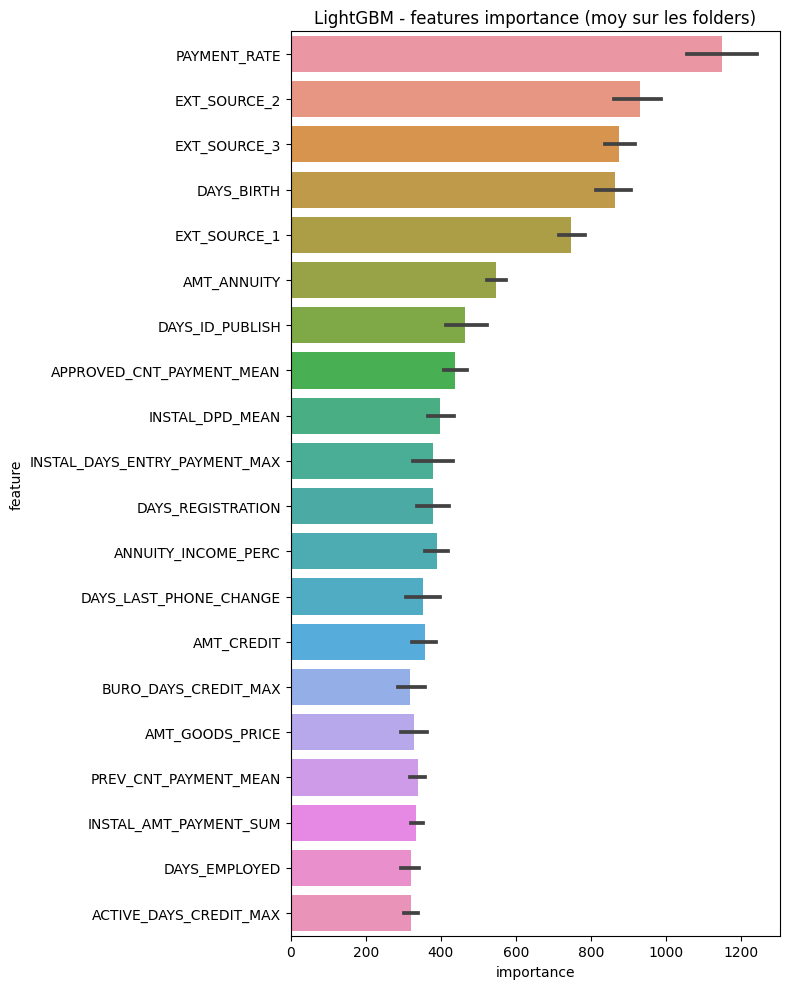

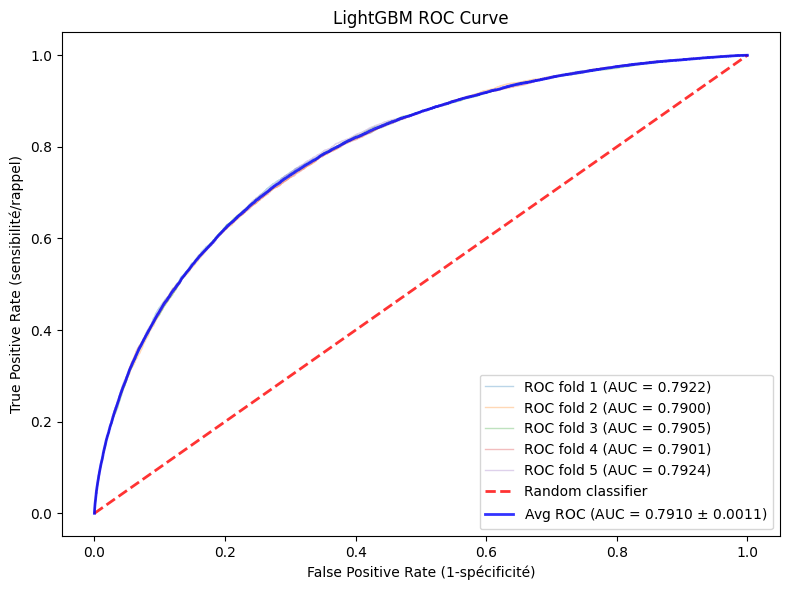

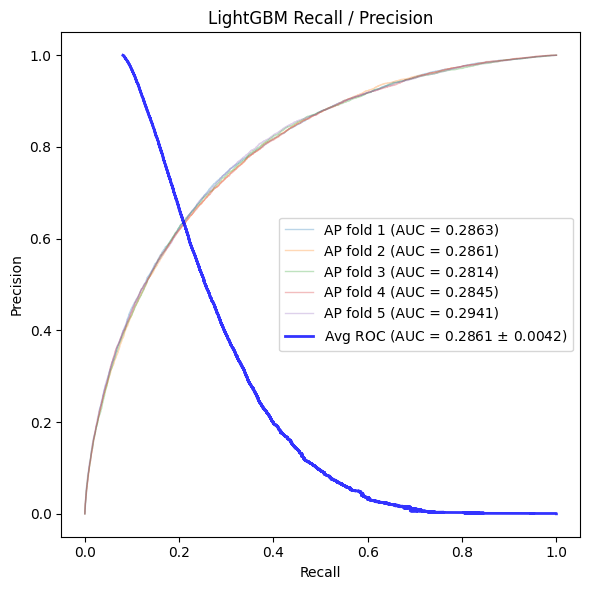

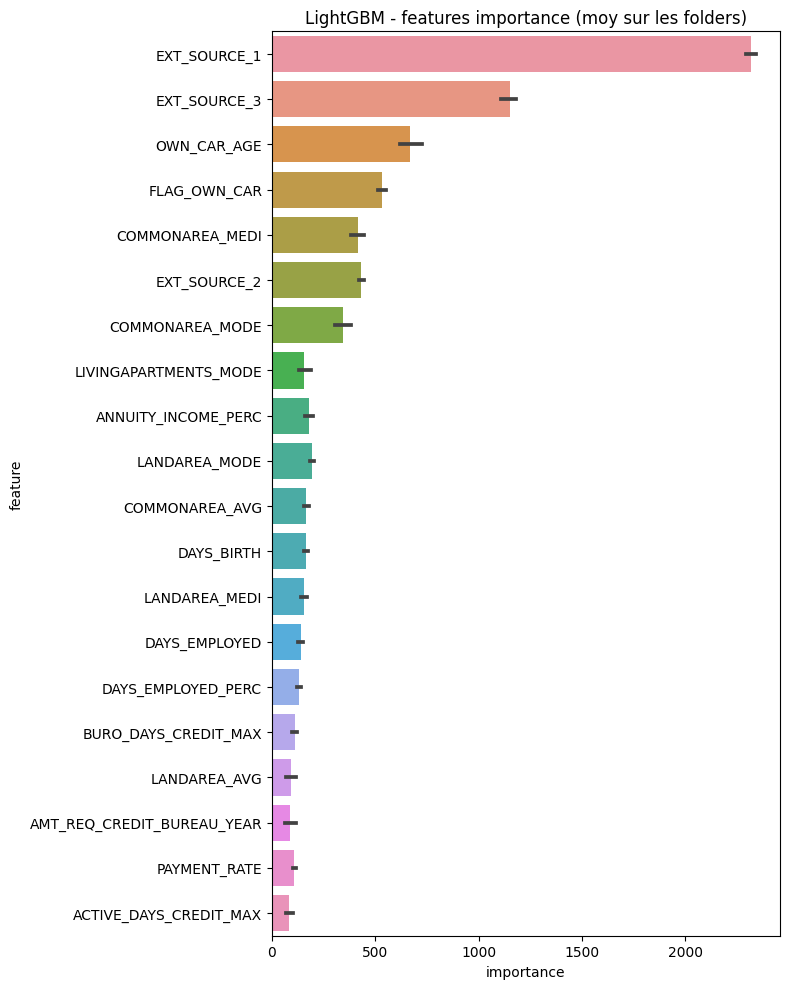

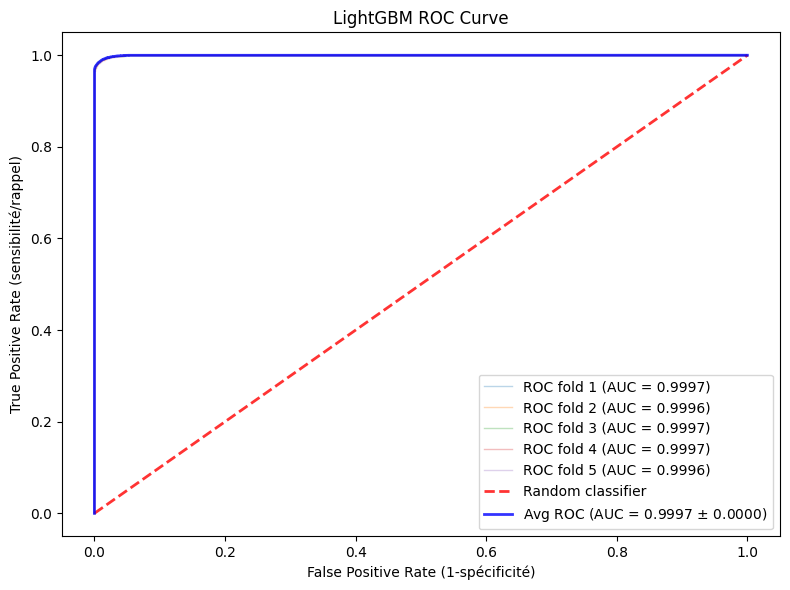

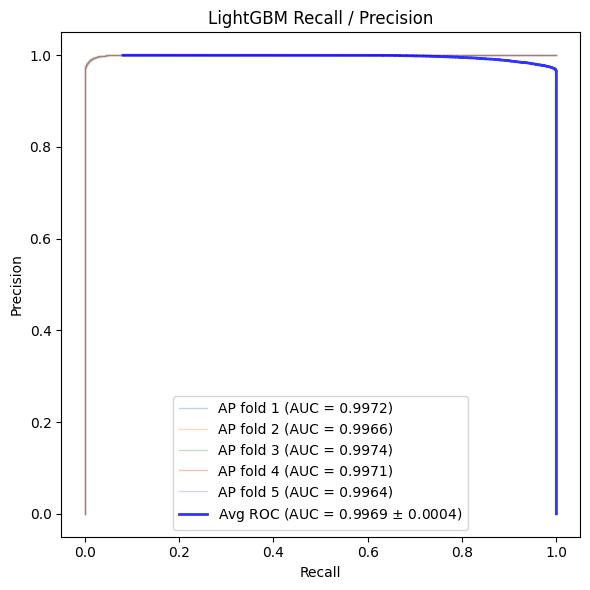

In [48]:
# Exécution ALL
fct_main(nan_as_category=True)

## IV.1. Features analysis
Top 20 des features les + importantes

In [49]:
# lecture du fichier scenario 0
#df_1 = df.save() # scenario 1
df = pd.read_csv('df_feat20_scenario_0.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
print(f"Check NaN :\n{(df.isna().mean()*100).sort_values(ascending=False)}")
feat20 = df.columns.tolist()
print('-'*50)
print(f'Top 20 features :\n{feat20}')

Check NaN :
TARGET                           13.682488
INSTAL_DAYS_ENTRY_PAYMENT_MAX     0.000000
DAYS_EMPLOYED                     0.000000
ACTIVE_DAYS_CREDIT_MAX            0.000000
AMT_GOODS_PRICE                   0.000000
INSTAL_AMT_PAYMENT_SUM            0.000000
PREV_CNT_PAYMENT_MEAN             0.000000
DAYS_LAST_PHONE_CHANGE            0.000000
AMT_CREDIT                        0.000000
DAYS_REGISTRATION                 0.000000
ANNUITY_INCOME_PERC               0.000000
PAYMENT_RATE                      0.000000
INSTAL_DPD_MEAN                   0.000000
APPROVED_CNT_PAYMENT_MEAN         0.000000
DAYS_ID_PUBLISH                   0.000000
AMT_ANNUITY                       0.000000
EXT_SOURCE_1                      0.000000
DAYS_BIRTH                        0.000000
EXT_SOURCE_3                      0.000000
EXT_SOURCE_2                      0.000000
BURO_DAYS_CREDIT_MAX              0.000000
dtype: float64
--------------------------------------------------
Top 20 features :
[

In [50]:
# Fonction de distribution type barplot pour la variable catégorielle "col"
def fct_bar(df, col):
    data = pd.DataFrame(df[col].value_counts(), columns=([col]))
    fig = plt.figure(figsize=(8,10))
    sns.barplot(data=data, y=data.index, x=col)
    plt.title('Distribution de {col}')
    plt.show()

In [51]:
# Fonction de distribution type histogramme pour la variable quantitative "col"
def fct_hist(df, col):
    fig = plt.figure(figsize=(5,5))
    #sns.displot(data=df, x=col, kind='kde', hue='TARGET')
    sns.kdeplot(data=df[df['TARGET']==0], x=col, label='Pas en défaut', color='g')
    sns.kdeplot(data=df[df['TARGET']==1], x=col, label='En défaut', color='r')
    plt.title(f'Distribution de {col}')
    plt.legend(loc='best')
    plt.show()

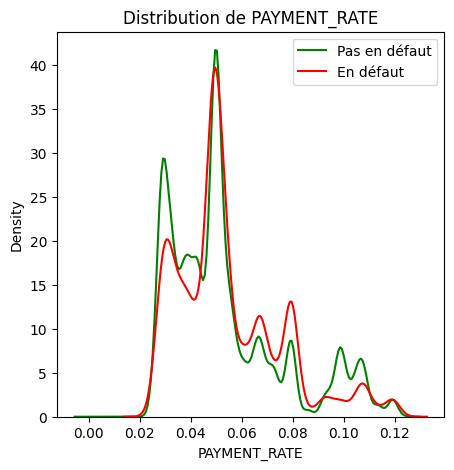

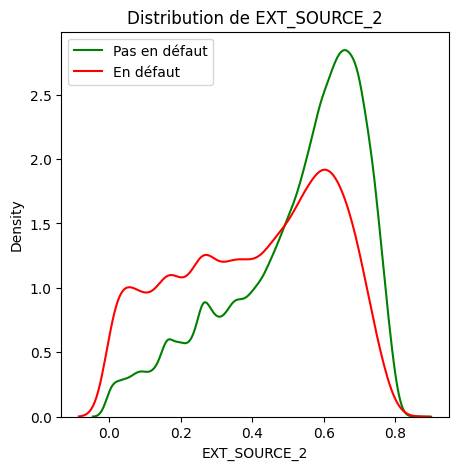

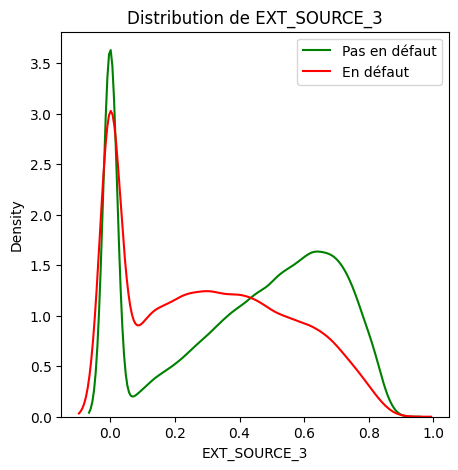

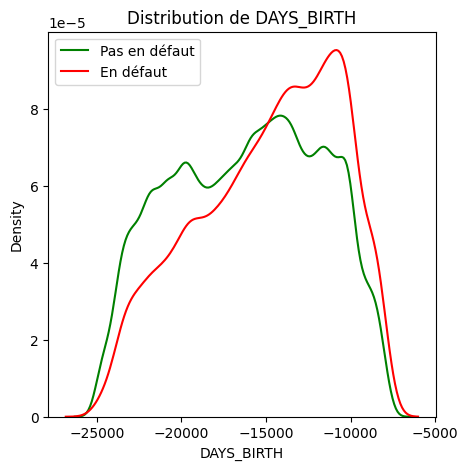

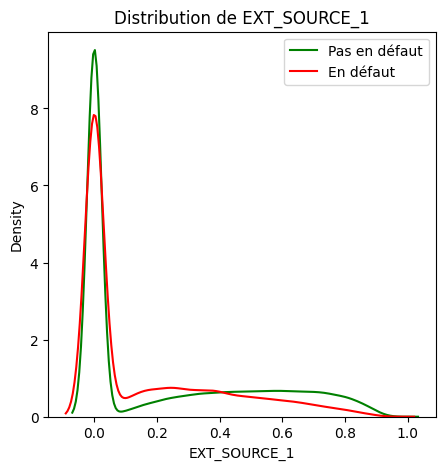

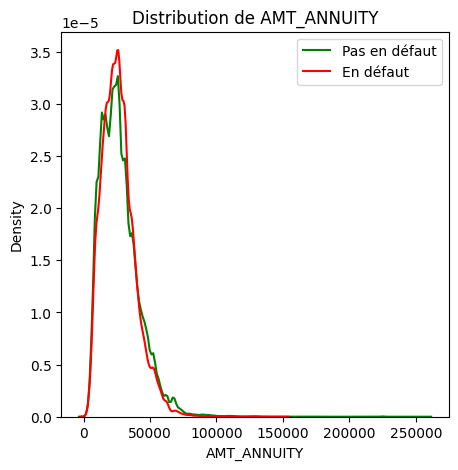

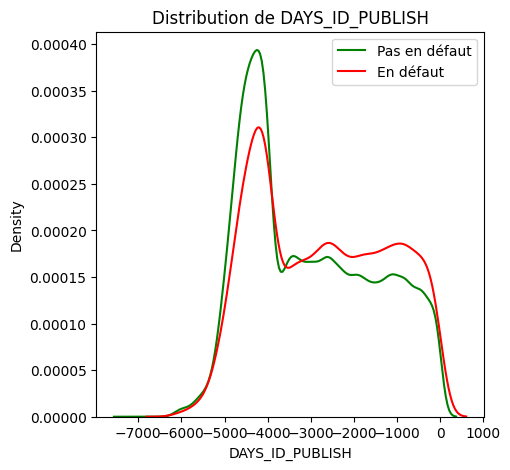

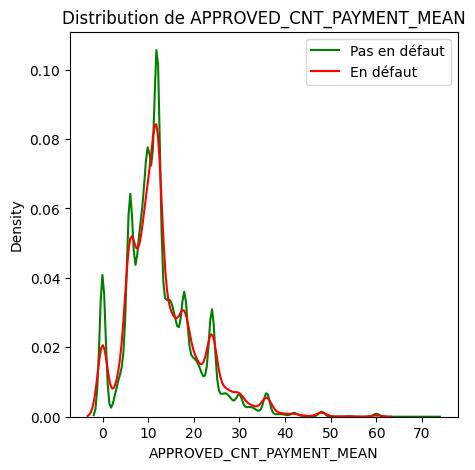

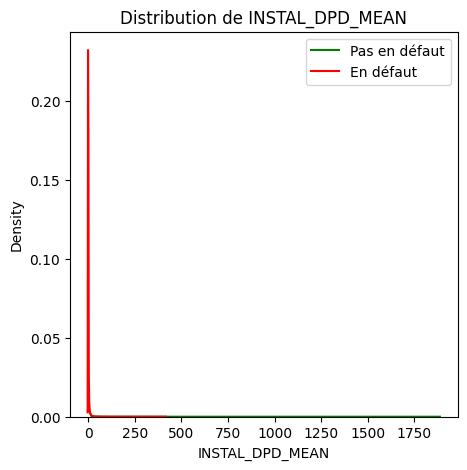

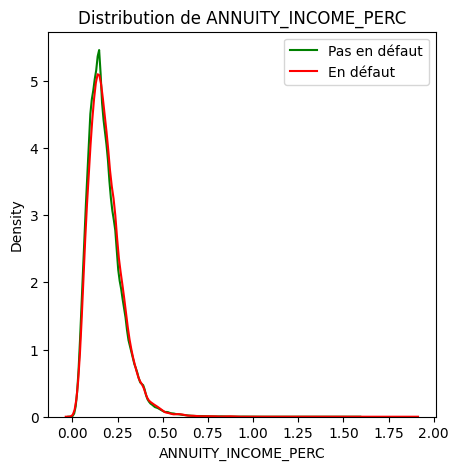

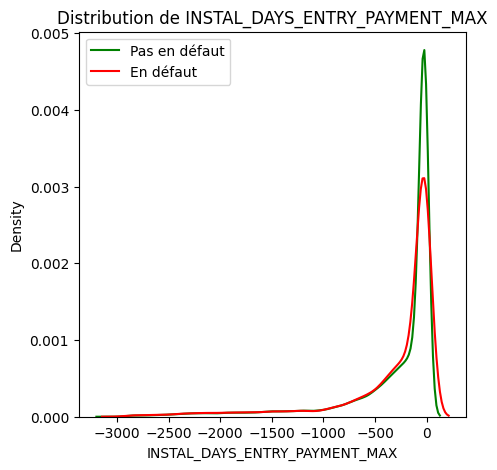

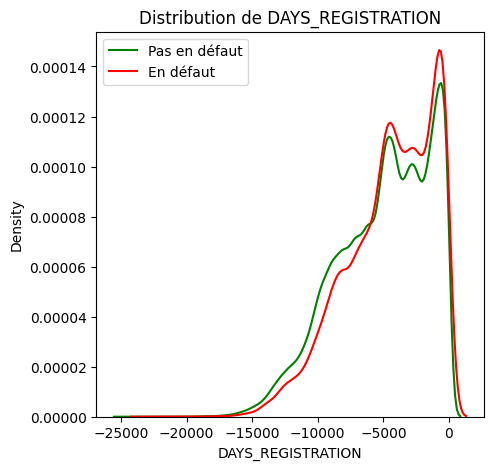

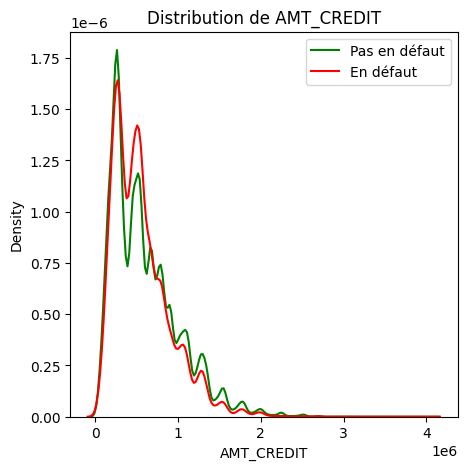

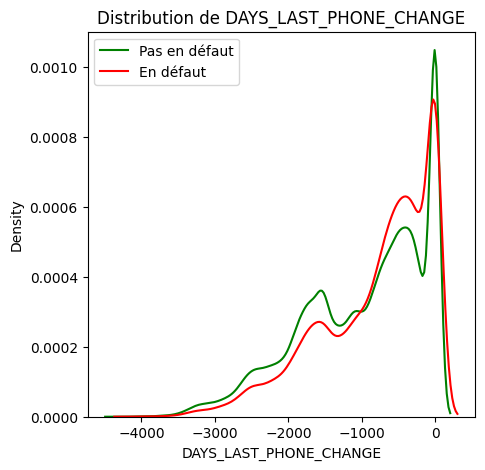

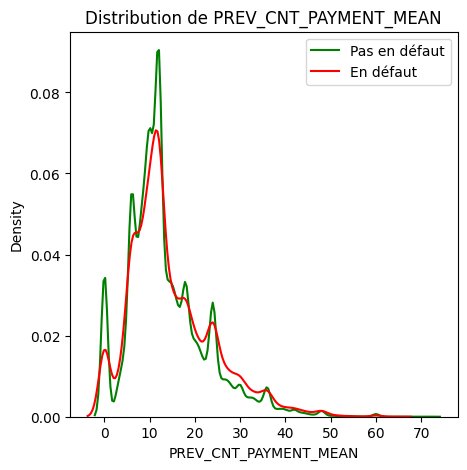

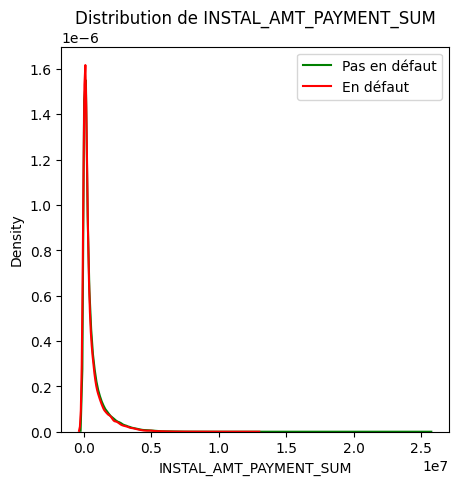

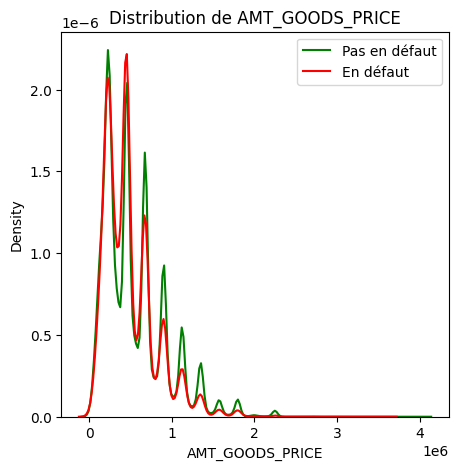

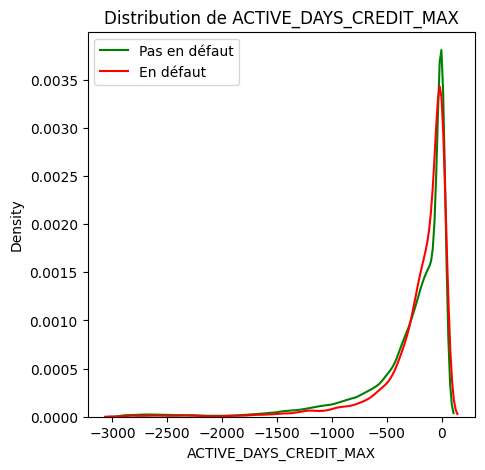

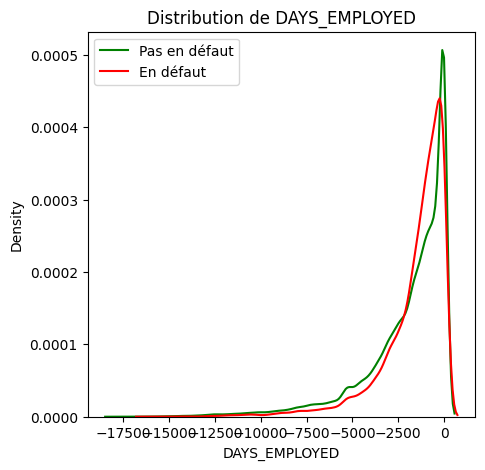

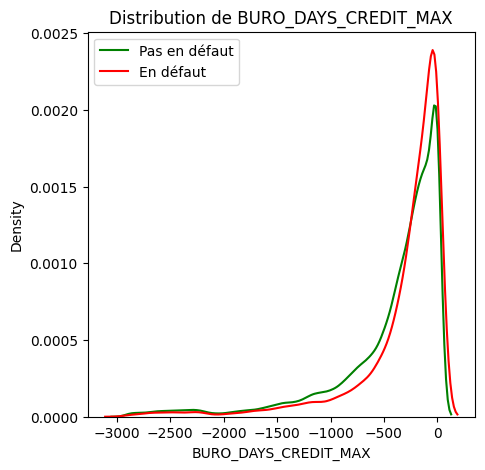

In [52]:
# Analyse des features top 20
for feat in [col for col in feat20 if col != 'TARGET']:
    fct_hist(df, feat)